First import ART package:

In [40]:
import sys
sys.path.append('../AutomatedRecommendationTool')
    
from art.core import *
import pickle

In [21]:
data_file = './data/training_data_8reactions_iso.csv'

In [22]:
df = pd.read_csv(data_file)

In [23]:
df.head()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM]
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.208611
2,3,1,0,0,2,1,1,2,0,0.309396
3,4,1,1,1,1,2,2,1,0,0.715185
4,5,2,0,2,1,1,0,1,1,0.118605


In [31]:
reactions = df.columns[1:-1].tolist()
response_var = df.columns[-1]
response_var


'Isoprenol [mM]'

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

In [32]:
n_reactions = len(reactions)
n_modifications = 3
reactions = reactions[:n_reactions]
tot_number_mod = n_modifications**n_reactions
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 6561
Training set size: 96 (1.46%)


In [33]:
df[df['Line Name']=='WT'][response_var]

95    0.552325
Name: Isoprenol [mM], dtype: float64

Text(0.5, 0, 'strains')

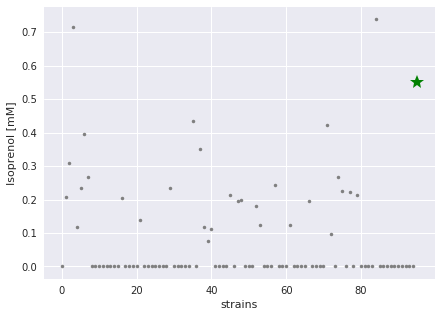

In [34]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(df[response_var],'.',color='grey')
ax.plot(95,df[df['Line Name']=='WT'][response_var],'g*',markersize=15)
ax.set_ylabel(response_var)
ax.set_xlabel('strains')

# Run ART with ordinal encoding of input variables

Pivot dataframe and change column names

In [35]:
df = df.set_index('Line Name').stack().reset_index()
df.columns = ['Line Name', 'Measurement Type', 'Value']
df.head()

,Line Name,Measurement Type,Value
0,1,ACCOAC,1.0
1,1,MDH,1.0
2,1,PTAr,2.0
3,1,CS,0.0
4,1,ACACT1r,2.0


## Train ART

Next define a dictionary that contains the settings that ART will use to find the recommended designs:

In [37]:
art_params = {}
art_params['response_var'] = [response_var]
art_params['input_var'] = reactions
art_params['seed'] = 10  
art_params['num_recommendations'] = 96   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = './results_ordinal/'

Run ART with seed (takes around 3h) or load previously run model.

In [38]:
run_art = False

In [41]:
%%time
if run_art:
    art = RecommendationEngine(df, **art_params)
else:
    with open('results_ordinal/art.pkl', 'rb') as output:
        art = pickle.load(output)

CPU times: user 276 ms, sys: 16 ms, total: 292 ms
Wall time: 289 ms


In [42]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.198925,inf,0.148100,0.061505,-1.612589
Random Forest Regressor,0.029029,NaN,0.063917,0.004928,0.790665
TPOT Regressor,0.020683,NaN,0.049773,0.002905,0.876597
Support Vector Regressor,0.095083,inf,0.091538,0.017420,0.260033
Kernel Ridge Regressor,0.079997,inf,0.089397,0.014391,0.388691
K-NN Regressor,0.101447,NaN,0.100111,0.020314,0.137119
Gaussian Process Regressor,0.086501,inf,0.090382,0.015651,0.335170
Gradient Boosting Regressor,0.055669,inf,0.074765,0.008689,0.630914
Ensemble Model,0.023440,inf,0.049696,0.003019,0.871754


In [43]:
os.rename(art.outDir + '/metric0.csv', art.outDir + '/metric.csv')
os.rename(art.outDir + '/cv_metric0.csv', art.outDir + '/cv_metric.csv')

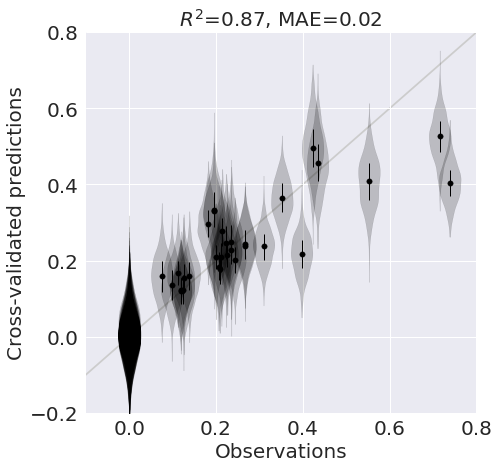

In [47]:
plot.predictions_distr_vs_observations(art, cv_flag=True, 
                                       xlim=[[-0.1, 0.8]], ylim=[[-0.2, 0.8]],
                                       widths=0.05)

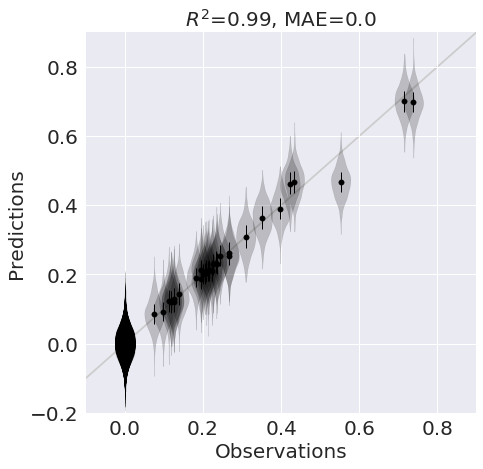

In [45]:
plot.predictions_distr_vs_observations(art, cv_flag=False, 
                                       xlim=[[-0.1, 0.9]], ylim=[[-0.2, 0.9]],
                                       widths=0.05)

In [48]:
utils.save_pkl_object(art)


## Recommend new designs

Create the set of all possible designs:

In [49]:
num_of_designs = n_modifications**n_reactions
num_of_designs_onehot = art.num_input_var
strains = np.zeros((num_of_designs, num_of_designs_onehot))
num_of_designs

6561

In [50]:
i = 0
designs = np.eye(3)

for d1 in range(3):
    for d2 in range(3):
        for d3 in range(3):
            for d4 in range(3):
                for d5 in range(3):
                    for d6 in range(3):
                        for d7 in range(3):
                            for d8 in range(3):
                                strains[i,:] = np.hstack((d1,d2,d3,d4,d5,d6,d7,d8)).astype(int)
                                i+=1

Calculate mean predicted production and standard deviation for all possible designs.

In [54]:
pp_mean, pp_std = art.post_pred_stats(strains)


The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [55]:
art.rel_eng_accuracy = 0.01

#### Exploitative approach

Objective function is defined as the mean predicted production (the parameter for exploration is set to $\alpha=0$).

In [56]:
obj_func = pp_mean 
data = np.hstack((strains, obj_func, obj_func))

In [57]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

Mean and standard deviation of the recommendation with the highest predicted production are: 0.70, 0.05


In [58]:
art.recommendations.head()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM]
0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,0.701705
1,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,0.700065
2,2.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.699911
3,1.0,0.0,2.0,1.0,2.0,2.0,2.0,1.0,0.699695
4,1.0,0.0,1.0,1.0,2.0,2.0,2.0,0.0,0.699205


In [59]:
os.rename(art.outDir + '/recommendations.csv', 
          art.outDir + '/recommendations_exploit.csv')


#### Explorative approach

Objective function is defined as the variance of the predicted production (the parameter for exploration is set to $\alpha=1$)

In [60]:
obj_func = pp_std 
data = np.hstack((strains, obj_func, obj_func))

In [61]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

Mean and standard deviation of the recommendation with the highest predicted production are: 0.69, 0.05


In [62]:
art.recommendations.head()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM]
0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683176
1,2.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681792
2,2.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.681940
3,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.677444
4,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.683688


In [63]:
os.rename(art.outDir + '/recommendations.csv', 
          art.outDir + '/recommendations_explor.csv')


In [68]:
rec = art.recommendations
n_rec = len(rec)

In [69]:
rec.loc[n_rec] = ['Summary'] + [[list(df[reaction]).count(int(i))/n_rec*100 
                                for i in range(3)]  for reaction in reactions] 
rec.iloc[-1]

KeyError: 'ACCOAC'